In [0]:
# importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
# carregando dados via raw github
data = pd.read_csv("https://raw.githubusercontent.com/mp-rocha/data-projects/master/heart-disease-predict/heart-disease-predict/heart.csv")

In [4]:
# proporção da classificação entre doentes e não doentes
data["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

In [5]:
# verificando missing datas
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [0]:
# definindo as variaveis explicativas e resposta

from sklearn.model_selection import train_test_split

y = data["target"]
X = data.drop(labels=["target"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
# dimensão dos dados
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [10]:
# treinamento de um modelo randomForest em sua forma padrão
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predict_rf = rf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# Modelo base

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predict_rf)

0.8232758620689656

In [12]:
# Instalando a biblioteca responsável pelo 'grid search' aprimorado
pip install scikit-optimize

     |████████████████████████████████| 81kB 6.1MB/s 


In [13]:
# criando função para treinar o modelo
# será usada como parâmetro
from skopt import dummy_minimize

def treinar_modelo(params):
  max_leaf_nodes = params[0]
  n_estimators = params[1]

  rf = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes, n_estimators = n_estimators)
  rf.fit(X_train, y_train)
  predict_rf = rf.predict_proba(X_test)[:,1]

  return -roc_auc_score(y_test, predict_rf)

space = [(2, 145), (50, 1000)]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
# Random Optimization - Busca de forma randomica os melhores parametros
resultado_random = dummy_minimize(treinar_modelo, dimensions=space, random_state=42, verbose=0)

# melhores parametros
print(resultado_random.x)

# precisão do melhor modelo
print(resultado_random.fun)

[114, 51]
-0.9423491379310345


In [0]:
# Bayesian Optimization - Busca o intervalo que possui os parametros que demonstrem melhores precisão (processos gaussianos)
# Exploration expploitation tradeoff

from skopt import gp_minimize

resultados_bayesian = gp_minimize(treinar_modelo, space, n_calls=30, n_random_starts=20, random_state=42, verbose=1)

# melhores parametros
print(resultados_bayesian.x)

# precisão do melhor modelo
print(resultados_bayesian.fun)

# - Entendendo o modelo utilizando a biblioteca SHAP

In [16]:
# Criando o melhor modelo segundo a tunagem de parametros

best_rf = RandomForestClassifier(n_estimators=51, max_leaf_nodes=114)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=114,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Instlando biblioteca shap
pip install shap

In [20]:
# importando biblioteca e carregando js
import shap
shap.initjs()

# maneiras de entender o funcionamento do modelo
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

In [74]:
# init js
shap.initjs()

# grafico shap para interpretar a predição de classe = 1 (chance de ter doença) para o primeiro individuo observado [0]
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

# interpretando [indivíduo possui 98% de possuir doença do coração]
# partindo de um valor base de 54% (oldpeak=0, slope=2, cp=1, age=42, thal=2, ca=0, incrementam as chances de ter doença cardiaca para 98%)

In [81]:
# init js
shap.initjs()

# grafico shap para interpretar a predição de classe = 0 (chance de não ter doença) para o indivíduo 3 [2]
shap.force_plot(explainer.expected_value[0], shap_values[0][2,:], X_train.iloc[2,:])

#interpretando [indivíduo possui 75% de NÃO possuir doença do coração]
# partindo de um valor base de 45% (oldpeak=3.6, incrementa as chances de ter doença cardiaca para 75%)

In [90]:
# valores das variaveis explicativas dos individuos analisados

print(X_train.loc[X_train.index == 132])
print(X_train.loc[X_train.index == 196])

     age  sex  cp  trestbps  chol  ...  exang  oldpeak  slope  ca  thal
132   42    1   1       120   295  ...      0      0.0      2   0     2

[1 rows x 13 columns]
     age  sex  cp  trestbps  chol  ...  exang  oldpeak  slope  ca  thal
196   46    1   2       150   231  ...      0      3.6      1   0     2

[1 rows x 13 columns]


In [92]:
# relação entre variavel e força preditora

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)

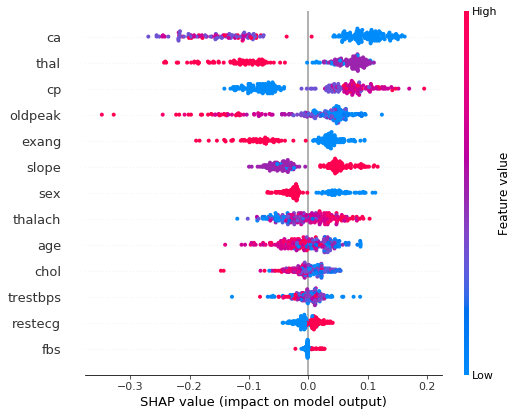

In [95]:
# summary plot - busca pelas features mais importantes

shap.initjs()
shap.summary_plot(shap_values[1], X_train)

In [0]:
# interpretando o summary plot
# Este gráfico mostra em ordem decrescente as variaveis com mais impacto no modelo, ou seja, que ajudam a incrementar mais ou menos as predições.
# A variável thal, possui muitos pontos aglomerados para direita, isso significa que quando valores baixos (cor azul) estão presentes nos dados observados
# o modelo tende a aumentar as chances (em até 10%) de classificar como portador de doença cardiaca. Qnd os valores dessa variável é baixo, o modelo tende
# a penalizar a predição de ser portador de doença cardiaca em até (20%).
# Cada ponto significa um valor observado e como ele foi avaliado.
# A variavel rastecg tem pouco impacto no modelo, porem é notório o aumento da força preditiva para portador de doença quando os valores são mais altos.

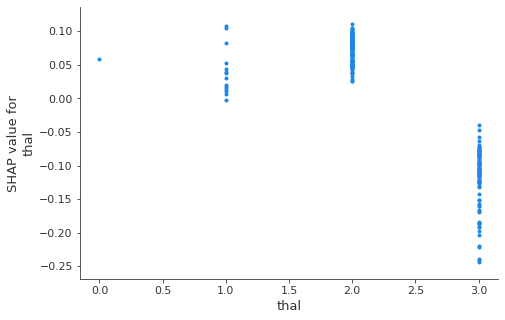

In [108]:
# dependece plot - seleciona uma feature por vez para analise específica (como a variação da feature afeta a previsão)

# interaction_index = None faz com que analise a feature de forma separada, caso queira fazer uma análise conjunta colocar nome de outra feature
# verificando a variável preditora e categorica 'thal'
shap.initjs()
shap.dependence_plot("thal", shap_values[1], X_train, interaction_index=None)

In [0]:
# interpretando dependence plot

# valores de thal = [0, 1, 2] aumentam as chances de doença entre 5 e 10% pelo modelo
# valoresde thal = [3] diminuem as chances de doença de 5 à 25% pelo modelo.

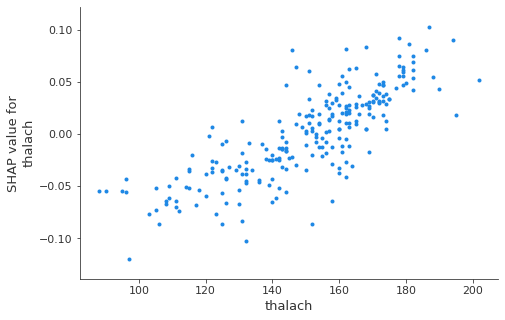

In [105]:
# verificando a variável preditora e contínua 'thalach'
# interaction_index = None faz com que analise a feature de forma separada, caso queira fazer uma análise conjunta colocar nome de outra feature
shap.initjs()
shap.dependence_plot("thalach", shap_values[1], X_train, interaction_index=None)

In [0]:
# interpretando

# valores de thalach de 100 até 150, não afetam a probabilidade de ter a doença cardiaca.
# valores acima de 150 at

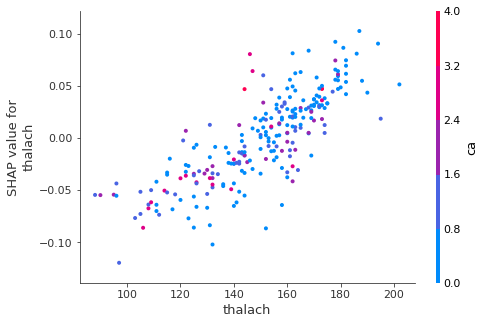

In [111]:
# verificando a variável preditora e contínua 'thalach'
# interaction_index = ca, análise com interação entre thalach x ca
shap.initjs()
shap.dependence_plot("thalach", shap_values[1], X_train, interaction_index="ca")